## Temporal Analysis
This notebook aims to analyse trend lines of sentiment over time
- Data Input: Combined dataset from core SIA Kaggle data and crawled Skytrax reviews (11,665)

### Import Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [32]:
df = pd.read_csv("data/cleaned_reviews_with_date.csv")
display(df.head())

,published_date,combined_review,sentiment_proxy
0,2024-03-12,ok we used this airline to go from singapore t...,neutral
1,2024-03-11,the service in suites class makes one feel lik...,positive
2,2024-03-11,don t give them your money booked paid and rec...,negative
3,2024-03-11,best airline in the world best airline in the ...,positive
4,2024-03-10,premium economy seating on singapore airlines ...,negative


In [33]:
df['published_dt'] = pd.to_datetime(df['published_date'], errors='coerce')
df['published_date'] = df['published_dt'].dt.date
df['published_year'] = df['published_dt'].dt.year
df['published_month'] = df['published_dt'].dt.month
df['published_dom'] = df['published_dt'].dt.day
df['published_dow'] = df['published_dt'].dt.dayofweek
df['published_dow_name']    = df['published_dt'].dt.day_name()

min_date = df['published_date'].min()
max_date = df['published_date'].max()

print(f"Date range: {min_date} -> {max_date}")

# counts by year (sorted)
print("\nCounts by year:")
year_counts = df['published_year'].value_counts().sort_index()
print(year_counts)

Date range: 2018-08-05 -> 2024-03-12

Counts by year:
published_year
2018    2621
2019    5201
2020     910
2021      85
2022     553
2023     534
2024      96
Name: count, dtype: int64


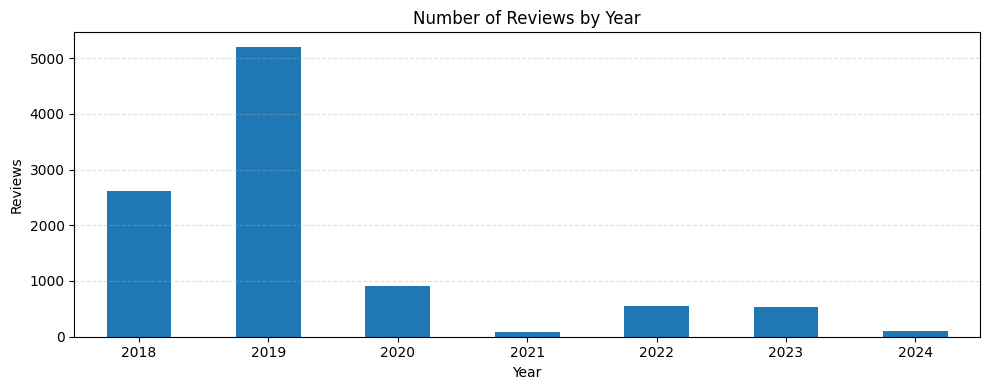

In [43]:
plt.figure(figsize=(10,4))
year_counts.plot(kind='bar')
plt.title('Number of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
display(df.head())

,published_date,combined_review,sentiment_proxy,published_dt,published_year,published_month,published_dom,published_dow,published_dow_name
0,2024-03-12,ok we used this airline to go from singapore t...,neutral,2024-03-12,2024,3,12,1,Tuesday
1,2024-03-11,the service in suites class makes one feel lik...,positive,2024-03-11,2024,3,11,0,Monday
2,2024-03-11,don t give them your money booked paid and rec...,negative,2024-03-11,2024,3,11,0,Monday
3,2024-03-11,best airline in the world best airline in the ...,positive,2024-03-11,2024,3,11,0,Monday
4,2024-03-10,premium economy seating on singapore airlines ...,negative,2024-03-10,2024,3,10,6,Sunday


In [35]:
# create polarity score for analysis
pol_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df['polarity'] = df['sentiment_proxy'].map(pol_map).astype(float)

### 1. Temporal Grouping (Daily/Weekly/Monthly/Yearly)

In [36]:
def aggregate_by(df, freq='D'):
    """freq: 'D' for daily, 'W' for weekly (Mon to Sun), 'M' for monthly, 'Y' for yearly"""
    g = (df.set_index('published_dt')
           .groupby(pd.Grouper(freq=freq))
           .agg(
               n_reviews=('polarity','size'),
               mean_score=('polarity','mean'),
               pct_negative=('sentiment_proxy', lambda s: (s=='negative').mean()),
               pct_neutral =('sentiment_proxy', lambda s: (s=='neutral').mean()),
               pct_positive=('sentiment_proxy', lambda s: (s=='positive').mean()),
           )
           .reset_index()
           .rename(columns={'published_dt':'period'}))
    return g

daily = aggregate_by(df, 'D')
weekly = aggregate_by(df, 'W')
monthly = aggregate_by(df, 'M')
yearly  = aggregate_by(df, 'Y')

C:\Users\User\AppData\Local\Temp\ipykernel_9228\3421420537.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(freq=freq))
C:\Users\User\AppData\Local\Temp\ipykernel_9228\3421420537.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .groupby(pd.Grouper(freq=freq))


### 2. Visualisation for Trend Analysis

#### 2.1 Daily

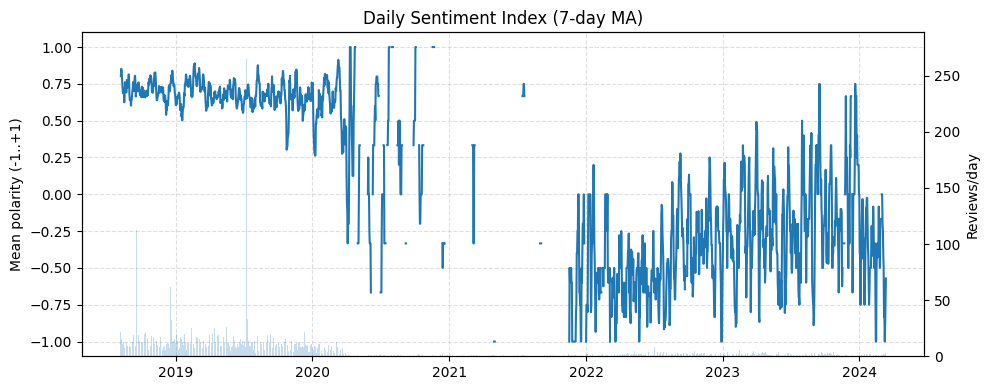

In [37]:
# Smooth the daily series using 7-day moving average
daily = daily.sort_values('period')
for col in ['mean_score','pct_negative','pct_neutral','pct_positive']:
    daily[f'{col}_ma7'] = daily[col].rolling(7, min_periods=3).mean()

# Plot: daily sentiment index + review volume
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(daily['period'], daily['mean_score_ma7'])
ax1.set_title('Daily Sentiment Index (7-day MA)')
ax1.set_ylabel('Mean polarity (-1..+1)')
ax1.grid(True, linestyle='--', alpha=0.4)

ax2 = ax1.twinx()
ax2.bar(daily['period'], daily['n_reviews'], alpha=0.25)
ax2.set_ylabel('Reviews/day')
plt.tight_layout()
plt.show()


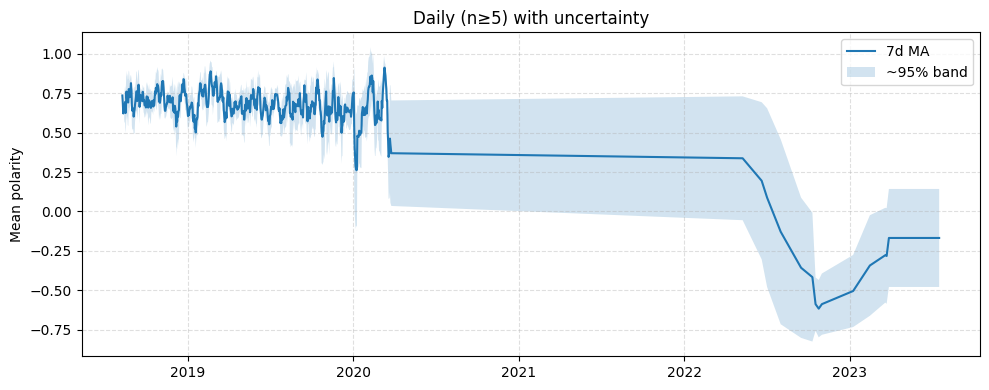

In [39]:
# Daily with n>=5 and confidence band
d = daily[daily['n_reviews']>=5].copy()
d['se'] = d['mean_score'].rolling(7).std() / np.sqrt(d['n_reviews'].rolling(7).mean())
d['ma'] = d['mean_score'].rolling(7, min_periods=3).mean()
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(d['period'], d['ma'], label='7d MA')
ax.fill_between(d['period'], d['ma']-1.96*d['se'], d['ma']+1.96*d['se'],
                alpha=0.2, label='~95% band')
ax.legend(); ax.grid(True, ls='--', alpha=0.4)
ax.set_ylabel('Mean polarity'); ax.set_title('Daily (n≥5) with uncertainty')
plt.tight_layout(); plt.show()

#### 2.2 Weekly

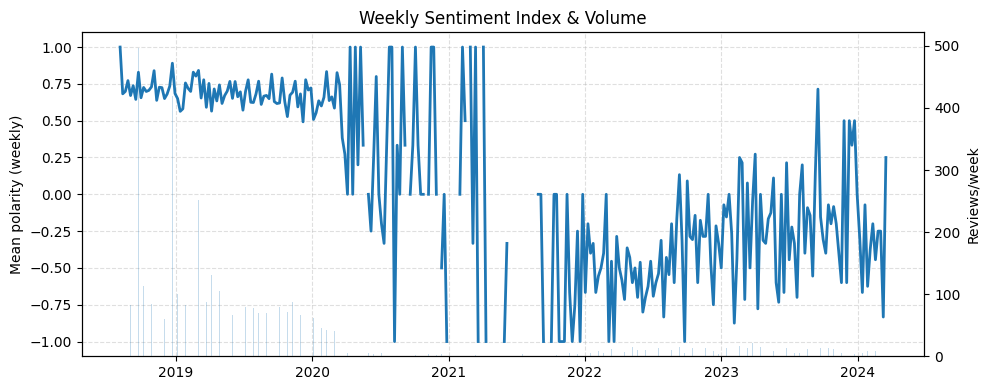

In [ ]:
# Plot weekly trend + volume
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(weekly['period'], weekly['mean_score'], linewidth=2)
ax1.set_ylabel('Mean polarity (weekly)')
ax1.grid(True, ls='--', alpha=0.4)
ax2 = ax1.twinx()
ax2.bar(weekly['period'], weekly['n_reviews'], alpha=0.25)
ax2.set_ylabel('Reviews/week')
plt.title('Weekly Sentiment Index & Volume')
plt.tight_layout(); 
plt.show()

Interpretation:
- 2018–2019 mostly high (≈0.6–0.8). Clear deterioration through 2020–2021 with thin volume (pandemic). From 2022 the index climbs from negative toward neutral/positive; 2023–2024 oscillates around slightly negative to mildly positive.
- Votality during 2020-2021 where the mean score is going up and downs between extremes, possibly due to the drop in review volume during the pandemic when there were much fewer flights.

#### 2.3 Monthly

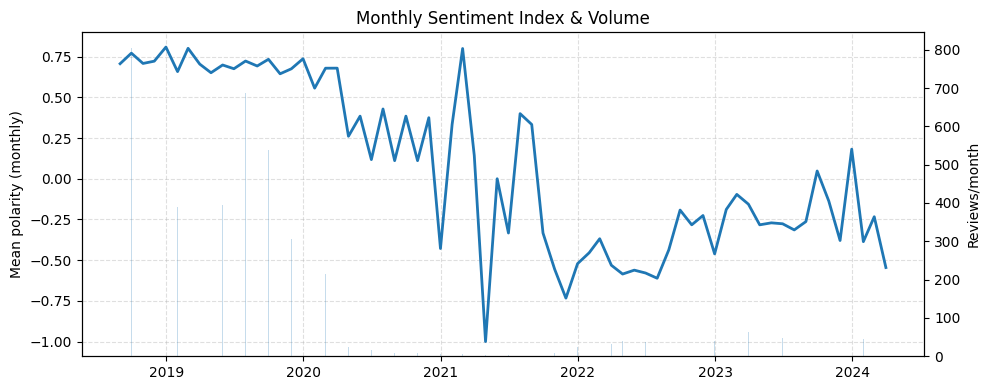

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(monthly['period'], monthly['mean_score'], linewidth=2)
ax1.set_ylabel('Mean polarity (monthly)')
ax1.grid(True, ls='--', alpha=0.4)
ax2 = ax1.twinx()
ax2.bar(monthly['period'], monthly['n_reviews'], alpha=0.25)
ax2.set_ylabel('Reviews/month')
plt.title('Monthly Sentiment Index & Volume')
plt.tight_layout(); plt.show()

Interpretation:
- the general trend is similar to what the weekly graph has shown.

#### 2.4 Yearly

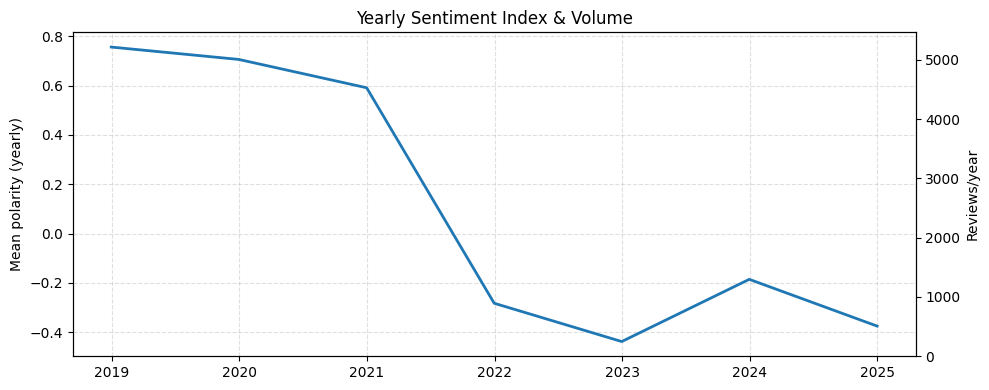

In [76]:
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(yearly['period'], yearly['mean_score'], linewidth=2)
ax1.set_ylabel('Mean polarity (yearly)')
ax1.grid(True, ls='--', alpha=0.4)
ax2 = ax1.twinx()
ax2.bar(yearly['period'], yearly['n_reviews'], alpha=0.25)
ax2.set_ylabel('Reviews/year')
plt.title('Yearly Sentiment Index & Volume')
plt.tight_layout(); plt.show()

### 3. Event-based Analysis

#### 3.1 Define event markers 

In [109]:
events = pd.DataFrame([
    {"name": "Mass network suspension (Pandemic)",
     "start": "2020-03-17"},
    {"name": "New B737-8 seats",
     "start": "2021-11-16"},
    {"name": "Private Room & First lounges reopen",
     "start": "2022-05-31"},
    {"name": "Unlimited free Wi-Fi",
     "start": "2023-07-01"},
])

events["start"] = pd.to_datetime(events["start"], errors="coerce")

events


,name,start
0,Mass network suspension (Pandemic),2020-03-17
1,New B737-8 seats,2021-11-16
2,Private Room & First lounges reopen,2022-05-31
3,Unlimited free Wi-Fi,2023-07-01


In [110]:
def annotate_events(ax, events, ymin=None, ymax=None, alpha=0.15):
    ymin = ymin if ymin is not None else ax.get_ylim()[0]
    ymax = ymax if ymax is not None else ax.get_ylim()[1]

    for _, ev in events.iterrows():
        s, label = ev["start"], ev["name"]
        COL = "tab:red"
        if label == "Mass network suspension (Pandemic)":
            COL = "tab:green"
        ax.axvline(s, color=COL, lw=1.5, ls="--", alpha=0.8)
        ax.text(s, ymax, f" {label}", color=COL,
                va="top", ha="left", rotation=90, fontsize=10)
    

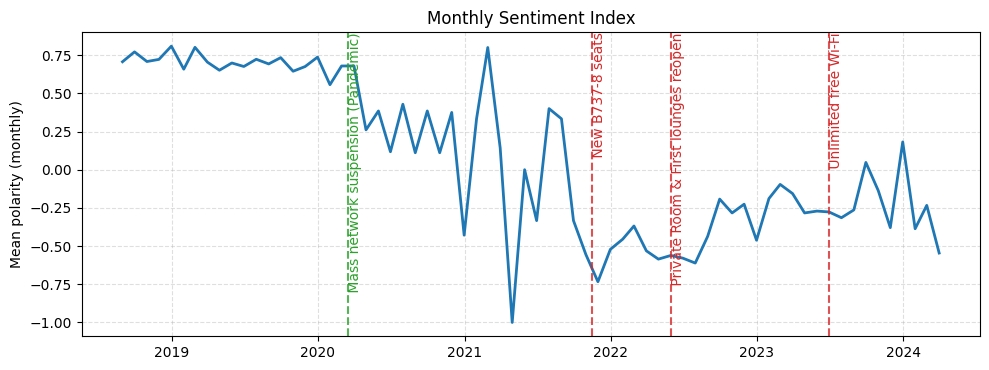

In [111]:
fig, ax = plt.subplots(figsize=(10,3.8))
ax.plot(monthly["period"], monthly["mean_score"], lw=2)
ax.set_title("Monthly Sentiment Index")
ax.set_ylabel("Mean polarity (monthly)")
ax.grid(True, ls="--", alpha=0.4)
annotate_events(ax, events)
plt.tight_layout(); plt.show()

In [112]:
def summarize_window(df_time: pd.DataFrame, start, end, label: str) -> pd.Series:
    sub = df_time[(df_time["period"] >= start) & (df_time["period"] <= end)]
    return pd.Series({
        "segment": label,
        "weeks": int(len(sub)),
        "n_reviews": int(sub["n_reviews"].sum()),
        "mean_score": sub["mean_score"].mean(),
        "pct_negative": sub["pct_negative"].mean(),
    })

def compare_event_weekly_startonly(
    weekly_df: pd.DataFrame,
    ev_row: pd.Series,
    pre_weeks: int = 8,
    post_weeks: int = 8,
    gap_days: int = 0,
):
    """
    Windows:
        PRE  = [start - pre_weeks,  start - 1 - gap_days]
        POST = [start + 1 + gap_days, start + post_weeks]
    """
    s = pd.to_datetime(ev_row["start"])

    pre_start = s - pd.Timedelta(weeks=pre_weeks)
    pre_end = s - pd.Timedelta(days=1 + gap_days)
    post_start = s + pd.Timedelta(days=1 + gap_days)
    post_end = s + pd.Timedelta(weeks=post_weeks)

    pre = summarize_window(weekly_df, pre_start,  pre_end,  "pre")
    post = summarize_window(weekly_df, post_start, post_end, "post")

    out = pd.DataFrame([pre, post])
    out["event"] = ev_row["name"]
    out["start"] = s

    out["Δmean_score"] = out["mean_score"] - float(pre["mean_score"])
    out["Δpct_negative"]  = out["pct_negative"] - float(pre["pct_negative"])
    return out

# Build the impact table for all events
impact_tbl = pd.concat(
    [compare_event_weekly_startonly(weekly, ev, pre_weeks=4, post_weeks=8, gap_days=0)
     for _, ev in events.iterrows()],
    ignore_index=True
)

impact_tbl


,segment,weeks,n_reviews,mean_score,pct_negative,event,start,Δmean_score,Δpct_negative
0,pre,4,377,0.704234,0.113988,Mass network suspension (Pandemic),2020-03-17,0.000000,0.000000
1,post,8,97,0.481963,0.234737,Mass network suspension (Pandemic),2020-03-17,-0.222271,0.120749
2,pre,4,8,-0.750000,0.875000,New B737-8 seats,2021-11-16,0.000000,0.000000
3,post,8,43,-0.566667,0.767708,New B737-8 seats,2021-11-16,0.183333,-0.107292
4,pre,4,52,-0.565385,0.734982,Private Room & First lounges reopen,2022-05-31,0.000000,0.000000
5,post,8,96,-0.590352,0.726916,Private Room & First lounges reopen,2022-05-31,-0.024967,-0.008066
6,pre,4,51,-0.296429,0.578694,Unlimited free Wi-Fi,2023-07-01,0.000000,0.000000
7,post,8,66,-0.248864,0.576515,Unlimited free Wi-Fi,2023-07-01,0.047565,-0.002178


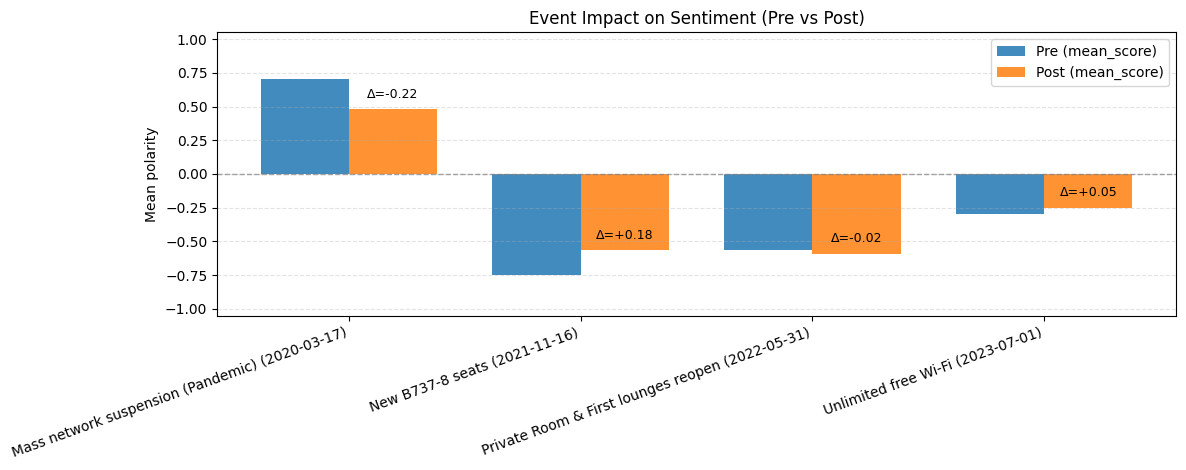

In [113]:
ev_order = (impact_tbl[['event','start']]
            .drop_duplicates()
            .sort_values('start', kind='mergesort'))
impact_tbl = impact_tbl.merge(ev_order, on=['event','start'], how='right')

ms = (impact_tbl.pivot_table(index=['event','start'], columns='segment', values='mean_score',aggfunc='mean')
                  .reset_index()
                  .sort_values('start'))
labels = (ms['event'] + ' (' + ms['start'].dt.date.astype(str) + ')').tolist()
pre = ms.get('pre')
post = ms.get('post')

x = np.arange(len(labels))
width = 0.38

fig, ax = plt.subplots(figsize=(12, 4.8))
b1 = ax.bar(x - width/2, pre,  width, label='Pre (mean_score)', alpha=0.85)
b2 = ax.bar(x + width/2, post, width, label='Post (mean_score)', alpha=0.85)

ax.axhline(0.0, color='grey', lw=1, ls='--', alpha=0.7)

# Annotate deltas above the post bars (Δ = post - pre)
delta = post.values - pre.values
for i, (px, py) in enumerate(zip(x + width/2, post.values)):
    if np.isfinite(py) and np.isfinite(delta[i]):
        ax.annotate(f"Δ={delta[i]:+0.2f}",
                    (px, py),
                    xytext=(0, 6), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

ax.set_title('Event Impact on Sentiment (Pre vs Post)')
ax.set_ylabel('Mean polarity')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha='right')
ax.set_ylim(-1.05, 1.05)
ax.grid(axis='y', linestyle='--', alpha=0.35)
ax.legend()
plt.tight_layout()
plt.show()